In [1]:
import yfinance as yf
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Fetch GE stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Define the MCMC model
def mcmc_model(data):
    with pm.Model() as model:
        # Priors for unknown model parameters
        mu = pm.Normal('mu', mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # Likelihood (sampling distribution) of observations
        returns = pm.Normal('returns', mu=mu, sigma=sigma, observed=data)
        
        # Posterior distribution
        trace = pm.sample(2000,tune=1000) # burn-in period-1000 # ,step=pm.Metropolis()
        
    return trace

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[*********************100%%**********************]  1 of 1 completed


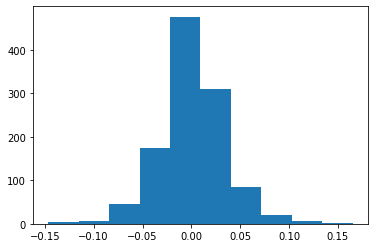

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu, sigma]


C:\Users\Jeff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\P
ython310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 612 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [2]:
# Fetch data
ticker = 'AMD'
start_date = '2020-01-01'
end_date = '2024-06-30'
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Calculate daily returns
stock_data['Returns'] = stock_data['Adj Close'].pct_change().dropna()
df=stock_data['Returns'].dropna()
plt.hist(stock_data['Returns'])
plt.show()

# Apply MCMC
trace = mcmc_model(df)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

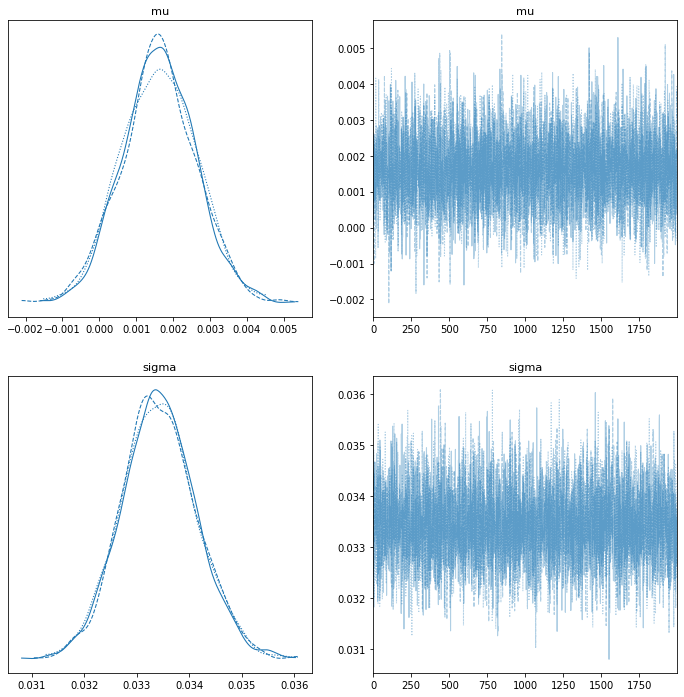

In [3]:
pm.plot_trace(trace, figsize=(12, 12))

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

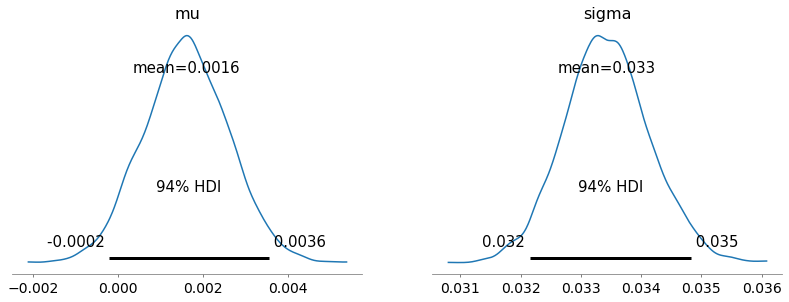

In [4]:
pm.plot_posterior(trace)

In [5]:
import scipy.stats as stats

mu_samples = trace.posterior['mu'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()

mean_mu = np.mean(mu_samples)
mean_sigma = np.mean(sigma_samples)

print(f"Posterior mean of mu (mean return): {mean_mu}")
print(f"Posterior mean of sigma (return standard deviation): {mean_sigma}")

# Calculate the z-score for a 2% return
z_score = (0.02 - mean_mu) / mean_sigma

# Calculate the p-value for the z-score
p_value = stats.norm.cdf(z_score)

# Probability of returns greater than 2%
prob_greater_than_2_percent = 1 - p_value

print(f"Probability of returns greater than 2%: {prob_greater_than_2_percent * 100:.2f}%")

Posterior mean of mu (mean return): 0.0016134314162533157
Posterior mean of sigma (return standard deviation): 0.033429393188066446
Probability of returns greater than 2%: 29.12%
